## Reading File Data to DataFrame

In [1]:
#import module
from pyspark.sql import SparkSession
from pyspark.sql.types import *

#create session in order to be capable of accessing all Spark API
spark = SparkSession \
    .builder \
    .appName("Introdution to Spark DataFrame") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

#define data schema for file we want to read
purchaseSchema = StructType([
    StructField("Date", DateType(), True),
    StructField("Time", StringType(), True),
    StructField("City", StringType(), True),
    StructField("Item", StringType(), True),
    StructField("Total", FloatType(), True),
    StructField("Payment", StringType(), True),
])    

# read csv file with our defined schema into Spark DataFrame, and use "tab" delimiter
purchaseDataframe = spark.read.csv(
    "salesData.csv", 
    header=True, schema=purchaseSchema, sep=",")  # Change sep="\t" to sep=","
purchaseDataframe.show(3)

+----------+-----+-------+-------+-------+-------+
|      Date| Time|   City|   Item|  Total|Payment|
+----------+-----+-------+-------+-------+-------+
|2020-07-10|15:25|Phoenix| Laptop| 911.56|   Cash|
|2020-03-03|20:02|Houston|Charger|1497.47| PayPal|
|2020-05-18|23:30|Houston|Charger|1440.46| PayPal|
+----------+-----+-------+-------+-------+-------+
only showing top 3 rows



## Counting number of rows, printing dataframe schema and printing statistic of our data

In [2]:
#count number of rows of our dataFrame
num_rows = purchaseDataframe.count()
print("number of rows: ", num_rows)
#show our dataFrame schema
purchaseDataframe.printSchema()
#show statistic of the data we want
purchaseDataframe.describe('Total').show()

number of rows:  1600000
root
 |-- Date: date (nullable = true)
 |-- Time: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Item: string (nullable = true)
 |-- Total: float (nullable = true)
 |-- Payment: string (nullable = true)

+-------+------------------+
|summary|             Total|
+-------+------------------+
|  count|           1600000|
|   mean|1004.7815742509503|
| stddev| 574.6892077378205|
|    min|              10.0|
|    max|            2000.0|
+-------+------------------+



## Creating a new dataFrame from a subset of our existing dataFrame

In [3]:
#create new dataFrame from "City" and "Total" columns
newDataframe = purchaseDataframe.select(purchaseDataframe['City'], 
                                              purchaseDataframe['Total'])
newDataframe.show(3); #menampilkan 3 baris DataFrame baru kita
newDataframe.printSchema() #print skema dari DataFrame baru kita

+-------+-------+
|   City|  Total|
+-------+-------+
|Phoenix| 911.56|
|Houston|1497.47|
|Houston|1440.46|
+-------+-------+
only showing top 3 rows

root
 |-- City: string (nullable = true)
 |-- Total: float (nullable = true)



## Adding a constant value to every row data in certain column

In [4]:
#adding constant value of 10 to every row data in "Total" column
purchaseDataframe.select(purchaseDataframe['City'],
                         purchaseDataframe['Total']+10).show(3)

+-------+------------+
|   City|(Total + 10)|
+-------+------------+
|Phoenix|      921.56|
|Houston|     1507.47|
|Houston|     1450.46|
+-------+------------+
only showing top 3 rows



## Filtering dataFrame using our defined condition

In [5]:
#filter only row data whose "Total" column value > 200
purchaseDataframe.filter(purchaseDataframe['Total'] > 200).show(3)

+----------+-----+-------+-------+-------+-------+
|      Date| Time|   City|   Item|  Total|Payment|
+----------+-----+-------+-------+-------+-------+
|2020-07-10|15:25|Phoenix| Laptop| 911.56|   Cash|
|2020-03-03|20:02|Houston|Charger|1497.47| PayPal|
|2020-05-18|23:30|Houston|Charger|1440.46| PayPal|
+----------+-----+-------+-------+-------+-------+
only showing top 3 rows



## Sorting dataFrame by certain column

In [6]:
sortedByCity = purchaseDataframe.orderBy('City').show(4)

+----------+-----+-------+----------+-------+-----------+
|      Date| Time|   City|      Item|  Total|    Payment|
+----------+-----+-------+----------+-------+-----------+
|2020-03-15|01:11|Chicago|    Laptop| 385.19| Debit Card|
|2020-09-01|11:40|Chicago|Headphones|1041.27|Credit Card|
|2020-10-28|05:32|Chicago|Headphones|1558.53|Credit Card|
|2020-05-14|21:05|Chicago|Headphones|  82.62| Debit Card|
+----------+-----+-------+----------+-------+-----------+
only showing top 4 rows



## Calculating number of transactions in each city

In [7]:
numTransactionEachCity = purchaseDataframe.groupBy("City").count()
numTransactionEachCity.show(5)

+-----------+------+
|       City| count|
+-----------+------+
|    Phoenix|320397|
|Los Angeles|320576|
|    Chicago|320420|
|    Houston|319726|
|   New York|318881|
+-----------+------+



## Indexing and Accessing DataFrame
Since Spark dataFrame is distributed into clusters, we cannot access it by [row,column] as in pandas dataFrame for example. There is an alternative way to do that by creating new column with "incremental ID". Then, we can access by row using ".filter()" function to our "incremental ID" column. 

In [8]:
#import monotonically_increasing_id
from pyspark.sql.functions import monotonically_increasing_id

newPurchasedDataframe = purchaseDataframe.withColumn(
    "index", monotonically_increasing_id())
newPurchasedDataframe.show(7)
row2Till4 = newPurchasedDataframe.filter((newPurchasedDataframe['index']>=2) &
                                         (newPurchasedDataframe['index']<=4))
row2Till4.show()

+----------+-----+-----------+----------+-------+----------+-----+
|      Date| Time|       City|      Item|  Total|   Payment|index|
+----------+-----+-----------+----------+-------+----------+-----+
|2020-07-10|15:25|    Phoenix|    Laptop| 911.56|      Cash|    0|
|2020-03-03|20:02|    Houston|   Charger|1497.47|    PayPal|    1|
|2020-05-18|23:30|    Houston|   Charger|1440.46|    PayPal|    2|
|2020-12-24|15:24|    Phoenix|    Tablet|  743.5|    PayPal|    3|
|2020-08-12|15:11|   New York|   Charger| 796.66|    PayPal|    4|
|2020-12-03|16:22|Los Angeles|Headphones| 182.77|Debit Card|    5|
|2020-04-20|09:05|Los Angeles|     Phone| 442.84|    PayPal|    6|
+----------+-----+-----------+----------+-------+----------+-----+
only showing top 7 rows

+----------+-----+--------+-------+-------+-------+-----+
|      Date| Time|    City|   Item|  Total|Payment|index|
+----------+-----+--------+-------+-------+-------+-----+
|2020-05-18|23:30| Houston|Charger|1440.46| PayPal|    2|
|2020-

Then, to access it by row and column, use ".select()" function we ever used above before.

In [9]:
dataRow2ColumnTotal = newPurchasedDataframe.filter(newPurchasedDataframe['index']==2).select('Total')
dataRow2ColumnTotal.show()

+-------+
|  Total|
+-------+
|1440.46|
+-------+



# Using SQL query in dataFrame

Create a new dataFrame from the subset of our existing dataFrame

In [10]:
#we need to make sql temporary view for our dataFrame
purchaseDataframe.createOrReplaceTempView("purchaseSql")

#select "Total" dan "Payment" column from our sql temporary view
anotherNewDataframe = spark.sql("SELECT Total, Payment FROM purchaseSql")
anotherNewDataframe.show(3)

+-------+-------+
|  Total|Payment|
+-------+-------+
| 911.56|   Cash|
|1497.47| PayPal|
|1440.46| PayPal|
+-------+-------+
only showing top 3 rows



Sorting data by certain column

In [11]:
#sorting data by "City" column alphabetically
orderByCity = spark.sql("SELECT * FROM purchaseSql ORDER BY City")
orderByCity.show(5)

+----------+-----+-------+-------+-------+-----------+
|      Date| Time|   City|   Item|  Total|    Payment|
+----------+-----+-------+-------+-------+-----------+
|2020-12-19|09:16|Chicago| Laptop|1319.89|       Cash|
|2020-12-22|12:59|Chicago| Laptop| 945.85|Credit Card|
|2020-03-19|20:29|Chicago| Laptop| 504.96| Debit Card|
|2020-08-02|19:04|Chicago|Charger|1977.21|     PayPal|
|2020-07-24|11:08|Chicago| Tablet|1513.16|     PayPal|
+----------+-----+-------+-------+-------+-----------+
only showing top 5 rows



The last one, we wil show how to filter data with "Total" column value > 200, and sort them by "Payment" column data.

In [12]:
#filter nilai kolom Total>50 dan urutkan berdasarkan cara pembayaran
filterAndSortWithSQL = spark.sql("SELECT * FROM purchaseSql WHERE Total>200 ORDER BY Payment")
filterAndSortWithSQL.show(4)

+----------+-----+--------+-------+-------+-------+
|      Date| Time|    City|   Item|  Total|Payment|
+----------+-----+--------+-------+-------+-------+
|2020-12-19|09:16| Chicago| Laptop|1319.89|   Cash|
|2020-04-09|21:22| Chicago| Laptop| 664.76|   Cash|
|2020-04-15|19:02|New York| Laptop|1138.33|   Cash|
|2020-10-26|12:09| Chicago|Charger|1471.14|   Cash|
+----------+-----+--------+-------+-------+-------+
only showing top 4 rows



In [13]:
!pip install numpy

You should consider upgrading via the 'c:\users\vboxuser\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [23]:
#import necessary ML libraries
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

In [25]:

# Convert categorical columns to numerical indices
city_indexer = StringIndexer(inputCol="City", outputCol="CityIndex")
payment_indexer = StringIndexer(inputCol="Payment", outputCol="PaymentIndex")

# Assemble features into a single vector
feature_assembler = VectorAssembler(
    inputCols=["CityIndex", "PaymentIndex", "Total"],
    outputCol="features"
)

# Define the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="Total")

# Build a pipeline to streamline the transformation and model training process
pipeline = Pipeline(stages=[city_indexer, payment_indexer, feature_assembler, lr])

# Split data into training and test sets
train_data, test_data = purchaseDataframe.randomSplit([0.8, 0.2])

# Fit the pipeline to the training data
lr_model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Show predictions
predictions.select("features", "Total", "prediction").show(5)

# Evaluate model performance using Root Mean Squared Error (RMSE)
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="Total", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data:", rmse)

+--------------------+-------+------------------+
|            features|  Total|        prediction|
+--------------------+-------+------------------+
|[1.0,2.0,477.5899...| 477.59| 477.5899963378904|
|[3.0,0.0,1245.180...|1245.18|1245.1800537109375|
|[4.0,0.0,1608.560...|1608.56|1608.5600585937502|
|[3.0,3.0,1633.239...|1633.24|1633.2399902343757|
|[3.0,3.0,1679.760...|1679.76|1679.7600097656257|
+--------------------+-------+------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data: 3.077358967442749e-13


The output Root Mean Squared Error (RMSE) on test data: 3.077358967442749e-13 indicates that the model's predictions are extremely close to the actual values, with an average error of approximately 
3.08
×
1
0
−
13
3.08×10 
−13
 . This is essentially negligible and suggests that the model has achieved near-perfect accuracy on the test dataset.

The features in the output are numerical representations of the original categorical columns in the dataset. These numbers are generated by StringIndexer and VectorAssembler in the pipeline. Here's how it works:

CityIndex: The StringIndexer converts the City column (which is categorical) into numeric values. For example, each unique city gets a corresponding index (e.g., "City 1" could become 1.0, "City 2" could become 2.0).

PaymentIndex: Similarly, StringIndexer converts the Payment column (which is also categorical) into numeric values (e.g., "Cash" could become 0.0, "Card" could become 1.0).

Total: This is the actual Total amount, which is already numeric (e.g., 477.59, 1245.18).

The VectorAssembler combines these individual numeric features into a single vector (e.g., [1.0, 2.0, 477.5899]), which is the input for the linear regression model.

So, the columns in the "features" are:

CityIndex (converted from "City")
PaymentIndex (converted from "Payment")
Total (original numeric value for "Total")

In [16]:
pip install pillow

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\vboxuser\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [17]:
pip install matplotlib

You should consider upgrading via the 'c:\users\vboxuser\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [18]:
pip install seaborn

You should consider upgrading via the 'c:\users\vboxuser\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas DataFrame for visualization
pandas_df = purchaseDataframe.toPandas()

C:\Users\vboxuser\AppData\Local\Temp\ipykernel_6408\2932125018.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='City', y='Total', data=city_sales, palette='viridis')


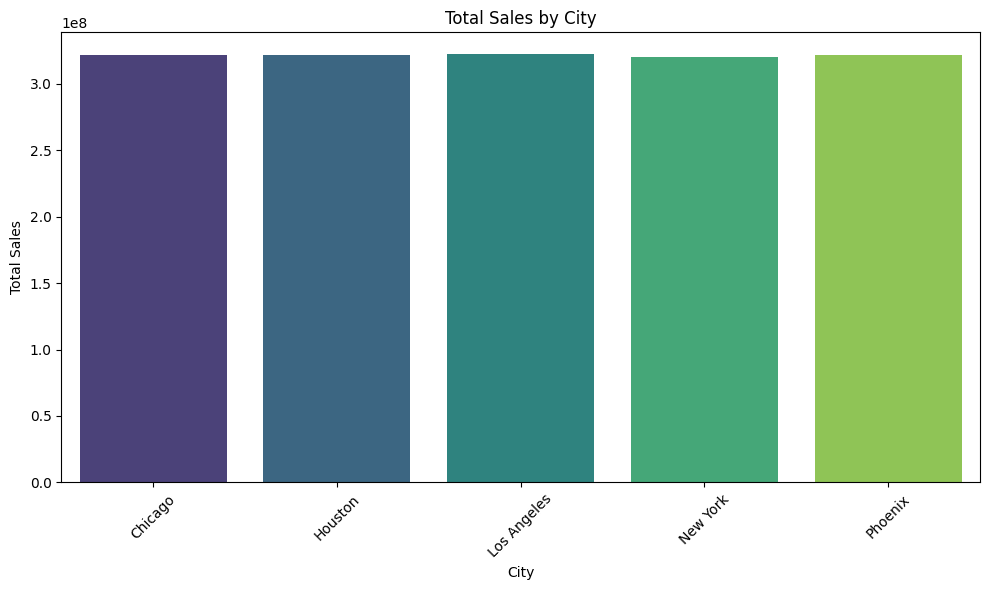

In [20]:
# 1. Bar plot of Total sales by City
city_sales = pandas_df.groupby('City')['Total'].sum().reset_index()  # Group by City and sum Total
plt.figure(figsize=(10, 6))
sns.barplot(x='City', y='Total', data=city_sales, palette='viridis')
plt.title('Total Sales by City')
plt.xlabel('City')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()